#test

In [244]:
#pip install Faker

In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from faker import Faker
fake = Faker()

In [246]:
df = pd.DataFrame(
    [
        {
            "first_name": fake.first_name(),
            "city": fake.city(),
            "postcode": fake.postcode(),
            "birthday": fake.date_time_this_year(),
            
        }
        for _ in range(100000)
    ]
)

df_dubl = df.head(10000)                      # выбрал первые строки сета (что бы копирнуть - создать дубли)
df = pd.concat([df, df_dubl])
df['postcode'] = df['postcode'].astype(int)   # поменял тип данных этого датасета (что бы соответствовать условию)
df = df.drop_duplicates()                     # удаляю дубли
df = df.dropna()                              # удаляю строки где нет пропусков значений числового типа данных  (в этом дата сете пропусков нет)
df['birthday'] = pd.to_datetime(df['birthday'])
df.set_index('birthday', inplace=True)        # нужно поменять индекс сделать временной ряд
idxs = df.index.indexer_between_time(
    "1:00", 
    "3:00", 
    include_start=True,
    include_end=True)

df = df.iloc[pd.Index(np.arange(len(df))).difference(idxs)]    # удаляю записи временного промежутка

df.to_csv(r"C:\Users\vtk_ru1\OneDrive - Servier Monde\Рабочий стол\Project ML\Skytec_test\skytec_test\fake.csv")  # создал датасет локалтно на компе


In [247]:
df = pd.read_csv(r"C:\Users\vtk_ru1\OneDrive - Servier Monde\Рабочий стол\Project ML\Skytec_test\skytec_test\fake.csv")
df['birthday'] = pd.to_datetime(df['birthday'])
metrics = df.groupby(df['birthday'].dt.floor('h')).agg(       # группировка 
    unique_city=('city', 'nunique'),                          # количество уникальных городов
    avg_postcode=('postcode', 'mean'),                        # среднее значение почтового индекса)
    median_postcode=('postcode', 'median')                    # медиана почтового индекса)
    )
metrics.to_csv(r"C:\Users\vtk_ru1\OneDrive - Servier Monde\Рабочий стол\Project ML\Skytec_test\skytec_test\metrics.csv")

In [248]:
# расчет метрик и мерж по условию ближайшего часа
metrics = pd.read_csv(r"C:\Users\vtk_ru1\OneDrive - Servier Monde\Рабочий стол\Project ML\Skytec_test\skytec_test\metrics.csv")
df['birthday'] = pd.to_datetime(df['birthday'])
metrics['birthday'] = pd.to_datetime(metrics['birthday'])
merged_df_metrics = pd.merge_asof(df.sort_values('birthday'), metrics.sort_values('birthday'), on='birthday', direction='nearest')
merged_df_metrics

,birthday,first_name,city,postcode,unique_city,avg_postcode,median_postcode
0,2024-01-01 00:01:43,Megan,Cherylberg,10808,21,51231.333333,62988.0
1,2024-01-01 00:02:18,Cindy,North Brian,33231,21,51231.333333,62988.0
2,2024-01-01 00:06:36,Kerri,New Johnport,55490,21,51231.333333,62988.0
3,2024-01-01 00:06:38,Rebecca,West Christianland,12355,21,51231.333333,62988.0
4,2024-01-01 00:16:58,Kimberly,Port Dale,66470,21,51231.333333,62988.0
...,...,...,...,...,...,...,...
91744,2024-07-30 11:23:07,Susan,South Kristymouth,10883,11,46727.727273,40398.0
91745,2024-07-30 11:23:32,Darrell,Port Brandon,40398,11,46727.727273,40398.0
91746,2024-07-30 11:24:41,Colleen,Carterview,30100,11,46727.727273,40398.0
91747,2024-07-30 11:24:56,Mercedes,Melissaberg,49932,11,46727.727273,40398.0


SELECT DATE_TRUNC('hour', birthday) AS period, COUNT(DISTINCT city) AS unique_city, AVG(postcode) AS avg_postcode, PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY postcode) AS median_postcode

FROM fake

GROUP BY DATE_TRUNC('hour', birthday);


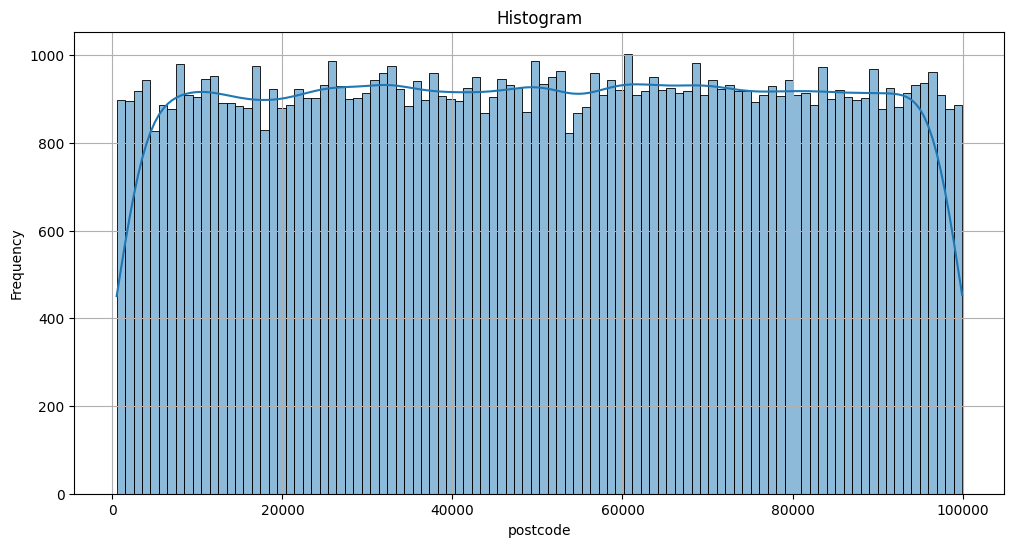

In [249]:
# гистограмма для колонки почтового индекса
plt.figure(figsize=(12, 6))
sns.histplot(df['postcode'], bins=100, kde=True)
plt.title('Histogram')
plt.xlabel('postcode')
plt.ylabel('Frequency')
plt.grid(True)

In [250]:
# аналитические метрики 
df = pd.read_csv(r"C:\Users\vtk_ru1\OneDrive - Servier Monde\Рабочий стол\Project ML\Skytec_test\skytec_test\fake.csv")
df['birthday'] = pd.to_datetime(df['birthday'])
confidence = 0.95                                                 # доверительный интервал
df_post = df[['birthday', 'postcode']]
df_post['birthday'] = pd.to_datetime(df_post['birthday'])
df_post.set_index('birthday', inplace=True) 

mean = np.mean(df_post)
std_err = stats.sem(df_post)
z_score = stats.norm.ppf(1 - (1 - confidence) / 2)
margin_of_error = z_score * std_err
confidence_interval = (mean - margin_of_error, mean + margin_of_error)

C:\Users\vtk_ru1\AppData\Local\Temp\ipykernel_12384\1863559843.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_post['birthday'] = pd.to_datetime(df_post['birthday'])


In [251]:
df_post['month'] = pd.DatetimeIndex(df_post.index).month # вынес отдельно  мясяц из индекса временного ряда

C:\Users\vtk_ru1\AppData\Local\Temp\ipykernel_12384\934163089.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_post['month'] = pd.DatetimeIndex(df_post.index).month # вынес отдельно  мясяц из индекса временного ряда


In [252]:
avg_month = df_post.groupby('month')['postcode'].mean() # группировка по месяцам среднего показателя почтового индекса (бред, но работаю с тем что  сгенерил)

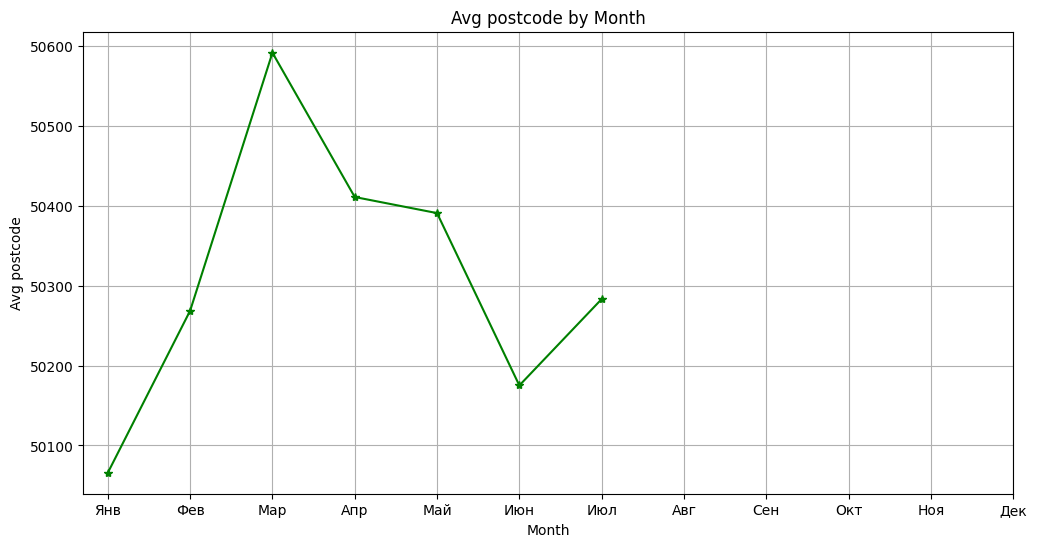

In [253]:
# визуализация на графике
plt.figure(figsize=(12, 6))
plt.plot(avg_month.index, avg_month.values, marker='*', color='g', linestyle='-')
plt.xticks(range(1, 13), ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
plt.title('Avg postcode by Month')
plt.xlabel('Month')
plt.ylabel('Avg postcode')
plt.grid(True)
plt.show()

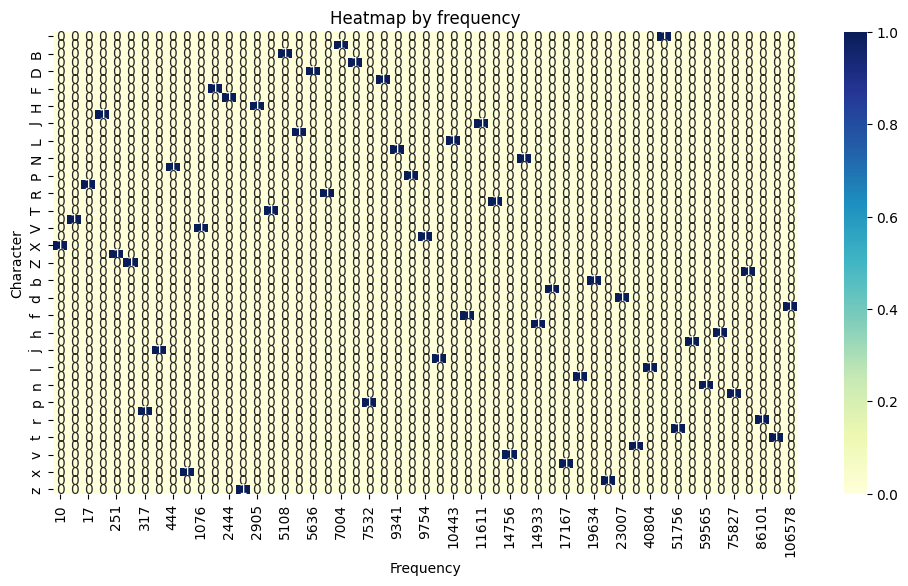

In [254]:
# Heatmap по частотности символов в колонке city
char_freq = df['city'].apply(lambda x: list(x)).explode().value_counts()
char_freq_df = char_freq.reset_index()
char_freq_df.columns = ['character', 'frequency']
plt.figure(figsize=(12, 6))
heatmap_df_post = char_freq_df.pivot_table(index='character', columns='frequency', aggfunc=len, fill_value=0)
sns.heatmap(heatmap_df_post, cmap="YlGnBu", annot=True, fmt='g')
plt.title('Heatmap by frequency')
plt.xlabel('Frequency')
plt.ylabel('Character')
plt.show()